In [1]:
import json
import os
import random
import numpy as np
from tqdm import tqdm

import torch
from tqdm import tqdm
import random
import seaborn as sns
from pylab import rcParams

from SkeletonData.data import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

### Add Skeleton of selected videos

In [2]:
#action_npz_file = "../data/skeleton_k10_v7_ movements.npz"
#action_arr = np.load(action_npz_file)

In [3]:
#for cls,arr,vid_n in zip(action_arr["arr_0"],action_arr["arr_1"],action_arr["arr_2"]):
#    os.makedirs(os.path.join(npz_files,f"{cls}"),exist_ok=True)
#    np.savez(os.path.join(npz_files,f"{cls}/{vid_n}.npz"),coords)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
mapping_l = [
        [15, 13], [13, 11], [11, 5],
        [12, 14], [14, 16], [12, 6],
        [3, 1],[1, 2],[1, 0],[0, 2],[2,4],
        [9, 7], [7,5], [5, 6],
        [6, 8], [8, 10],
        ]
#mapping_l = []

## Sequence Data

In [6]:
root_dir = "D:\\FYP\\HAR-ZSL-XAI\\AETraining"
main_dir = "D:\\FYP\\HAR-ZSL-XAI"
data_dir = os.path.join(main_dir,"pyskl/HRNetSkeletons/nipun_video_dataset/PAMAP2_K10_V1/combined.pkl")
refined_data = os.path.join(main_dir,"data","sequence_data","random_50f")
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1-train_ratio - val_ratio
batch_size = 32

In [7]:
class_names = os.listdir(os.path.join(main_dir,"data/nipun_video_dataset/PAMAP2_K10_V1"))

In [8]:
from SkeletonData.array_segment import *
from SkeletonData.visualize import *

In [9]:
pkl_reader = SkeletonPickleReader(file_path="D:/FYP/HAR-ZSL-XAI/pyskl/HRNetSkeletons/nipun_video_dataset/PAMAP2_K10_V1/combined.pkl")
#pkl_reader = SkeletonPickleReader(file_path="E:\\FYP_Data\\NTU120\\ntu120_hrnet.pkl")
anno = pkl_reader.generate(split=False)

In [10]:
files = FileDictIterator(anno)

In [11]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

### Visualize

In [12]:
def visualize_after_normalize(__f):
    kp = __f["keypoint"][0]
    kp[:,:,0] = kp[:,:,0]/__f["original_shape"][1]
    kp[:,:,1] = kp[:,:,1]/__f["original_shape"][0]

    gen_video(kp,f"temp_files/{__f['frame_dir']}.mp4",__f["original_shape"][0],__f["original_shape"][1],mapping_list=mapping_l)

    return f"temp_files/{__f['frame_dir']}.mp4"

In [13]:
os.makedirs("temp_files",exist_ok=True)

#with ThreadPoolExecutor() as executor:
#    file_loc = list(tqdm(executor.map(visualize_after_normalize,files), total=len(files),desc="Saved Videos:"))

### Break Into Segments

In [14]:
files = iter(files)

In [15]:
id2shapes = {}
for k,v in anno.items():
    id2shapes[k] = v["original_shape"]


id2shapes

{'as10': (1080, 1920),
 'as12': (1080, 1920),
 'as13': (1080, 1920),
 'as14': (1080, 1920),
 'as15': (1080, 1920),
 'as16': (1080, 1920),
 'as18': (1080, 1920),
 'as7': (1080, 1920),
 'as8': (1080, 1920),
 'as9': (1080, 1920),
 'cd11': (1080, 1920),
 'cd13': (1080, 1920),
 'cd14': (1080, 1920),
 'cd16': (1080, 1920),
 'cd18': (1080, 1920),
 'cd19': (1080, 1920),
 'cd2': (1080, 1920),
 'cd5': (1080, 1920),
 'cd6': (1080, 1920),
 'cd9': (1080, 1920),
 'cw10': (1080, 1920),
 'cw11': (1080, 1920),
 'cw13': (1080, 1920),
 'cw17': (1080, 1920),
 'cw18': (1080, 1920),
 'cw19': (1080, 1920),
 'cw2': (1080, 1920),
 'cw23': (1080, 1920),
 'cw24': (1080, 1920),
 'cw6': (1080, 1920),
 'c10': (1080, 1920),
 'c14': (1080, 1920),
 'c16': (1080, 1920),
 'c17': (1080, 1920),
 'c18': (1080, 1920),
 'c2': (1080, 1920),
 'c20': (1080, 1920),
 'c4': (1080, 1920),
 'c6': (1080, 1920),
 'c9': (1080, 1920),
 'ds1': (1080, 1920),
 'ds10': (1080, 1920),
 'ds12': (1080, 1920),
 'ds13': (1080, 1920),
 'ds18': (10

In [16]:
os.makedirs(refined_data,exist_ok=True)
#for each_file in tqdm(files,desc="Files Used",total=len(files)):
with ThreadPoolExecutor() as executor:
    file_loc = list(tqdm(executor.map(partial(split_array_main,id2shapes,refined_data),files), total=len(files),desc="Processed Files:"))

Processed Files:: 100%|██████████| 177/177 [00:00<00:00, 737.57it/s]


In [17]:
class_per_file = [x.split("_cls_")[0] for x in os.listdir(refined_data)]

In [18]:
unique_val,unique_count = np.unique(class_per_file,return_counts=True)

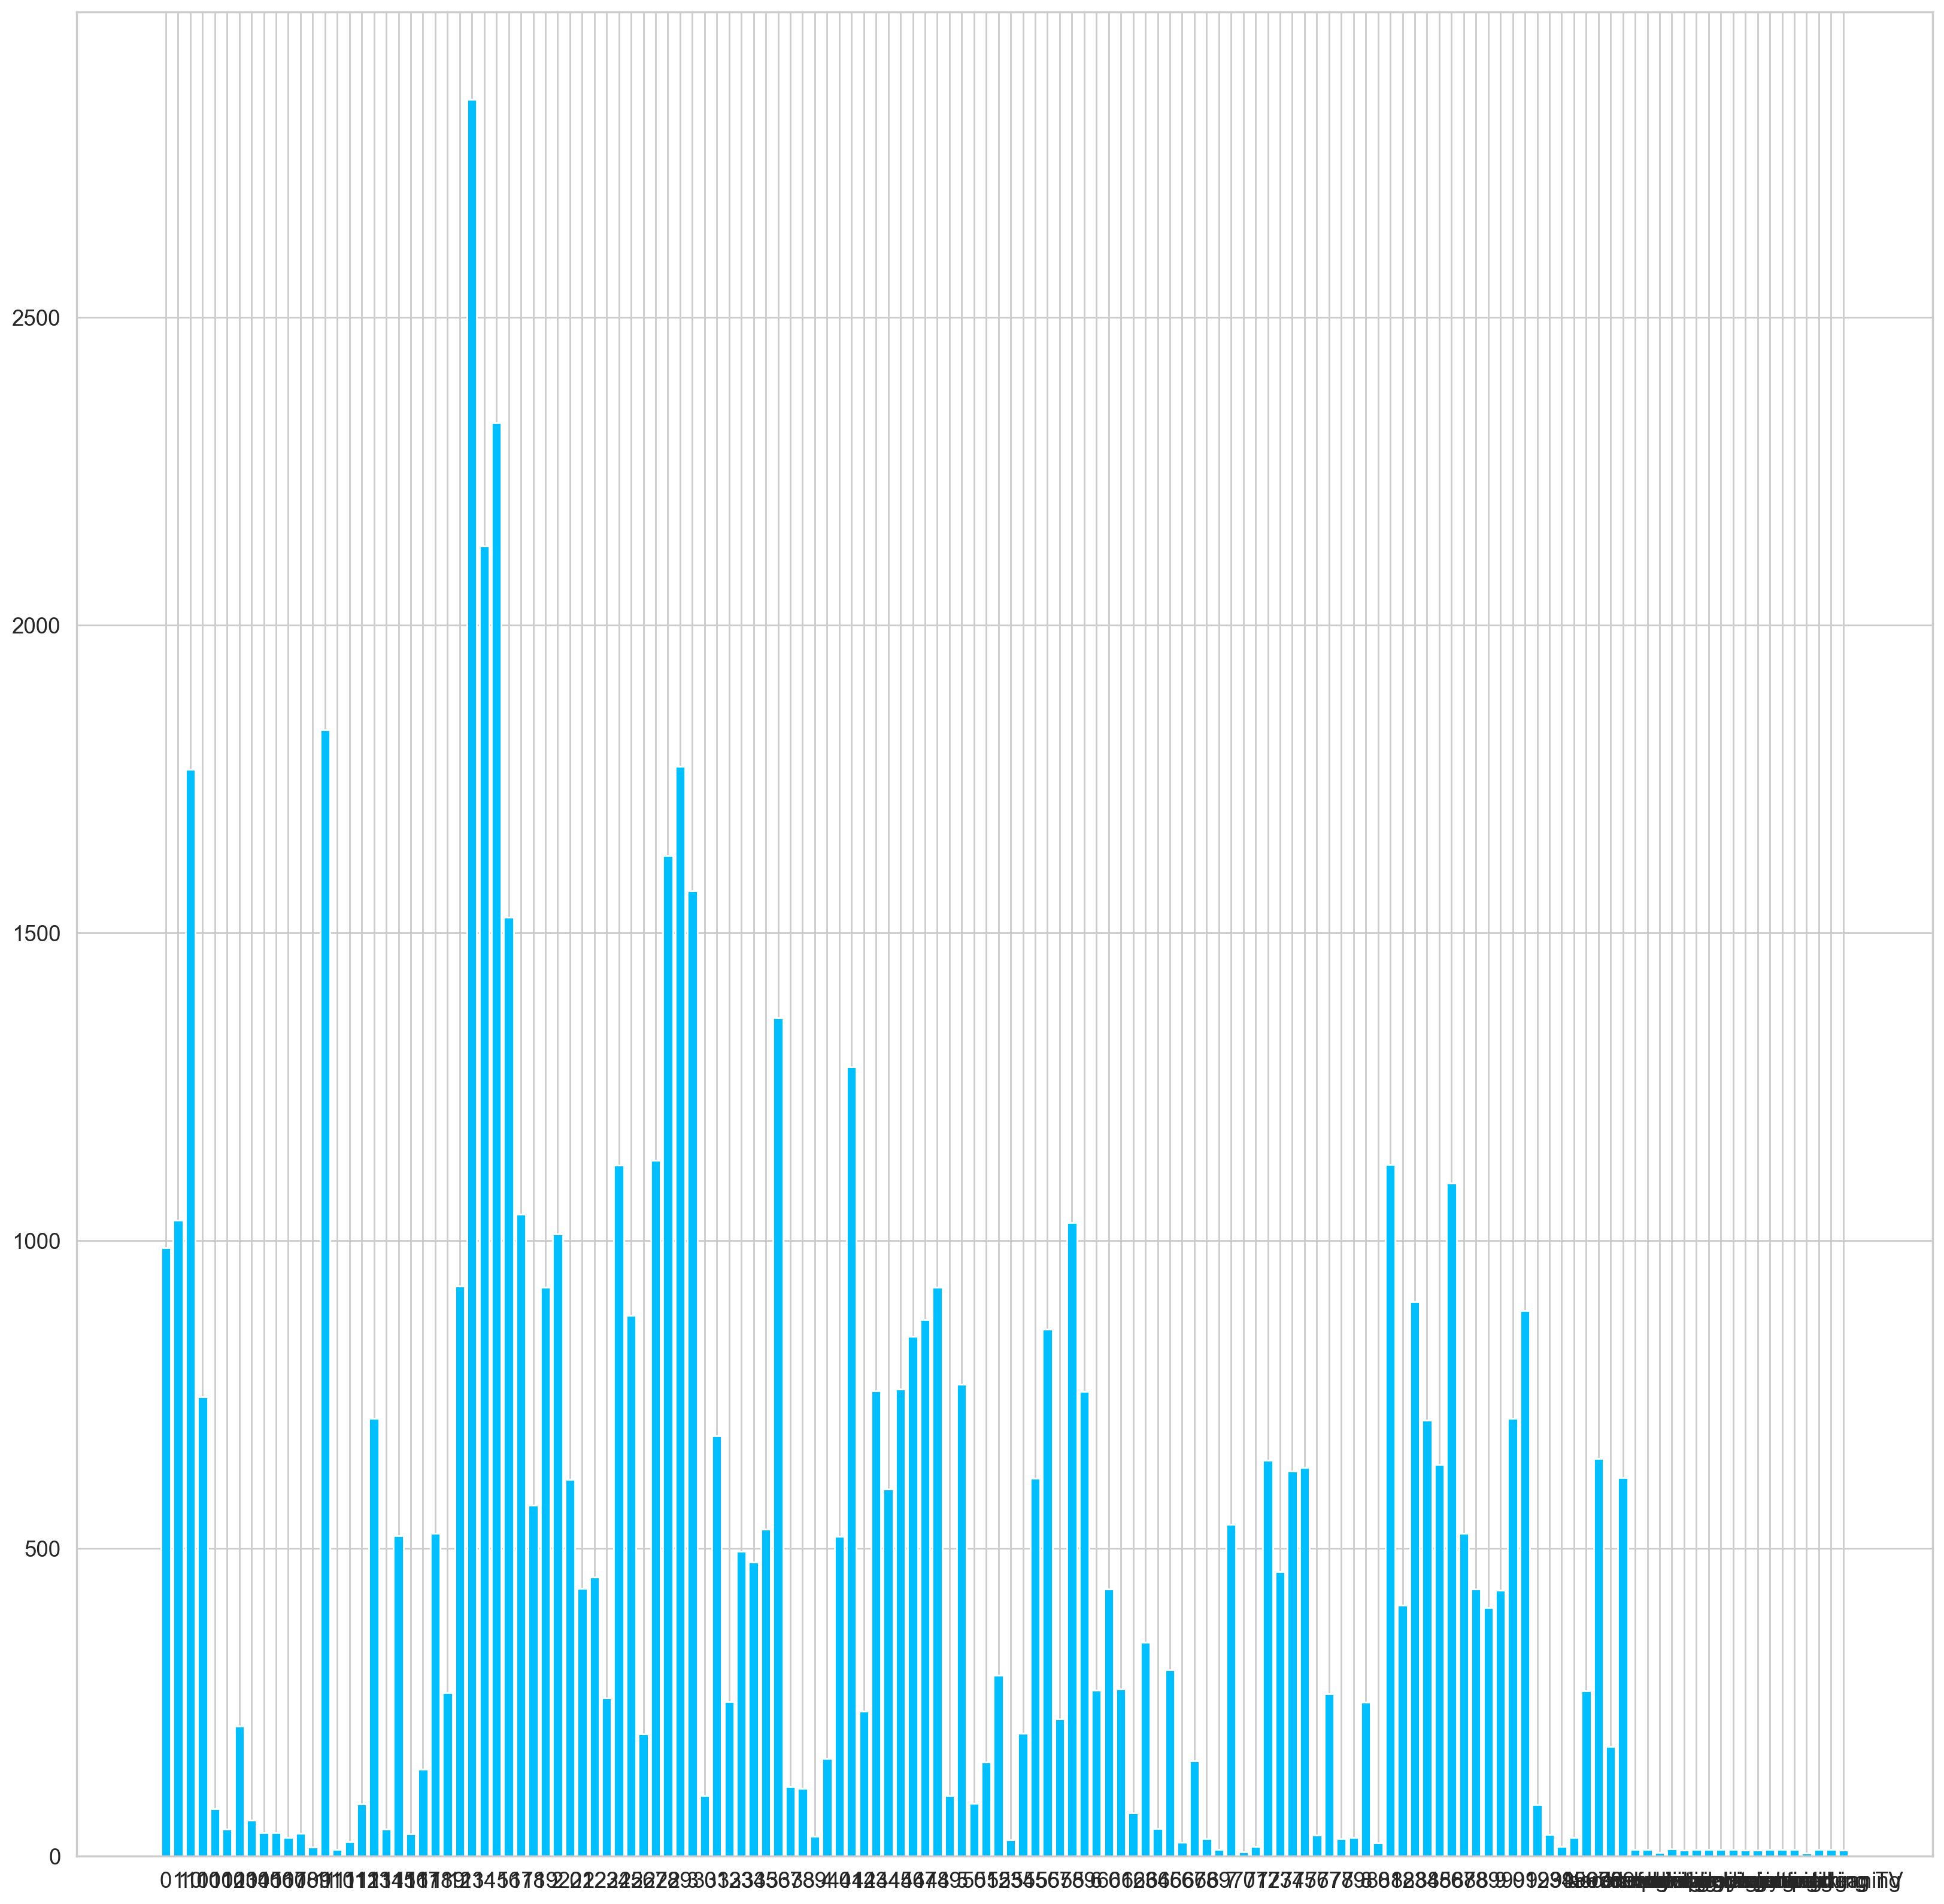

In [19]:
import pandas as pd
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20, 20))

plt.bar(unique_val, unique_count)

# Show Plot
plt.show()

In [20]:
class_per_file = [x.split(".")[0].split('A')[1] for x in os.listdir("E:\\FYP_Data\\NTU120\\skel\\nturgbd_skeletons_s001_to_s032\\nturgb+d_skeletons")]

In [21]:
class_per_file = list(map(lambda x: str(int(x)),class_per_file))

In [22]:
class_per_file

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27'

In [23]:
unique_val,unique_count = np.unique(class_per_file,return_counts=True)

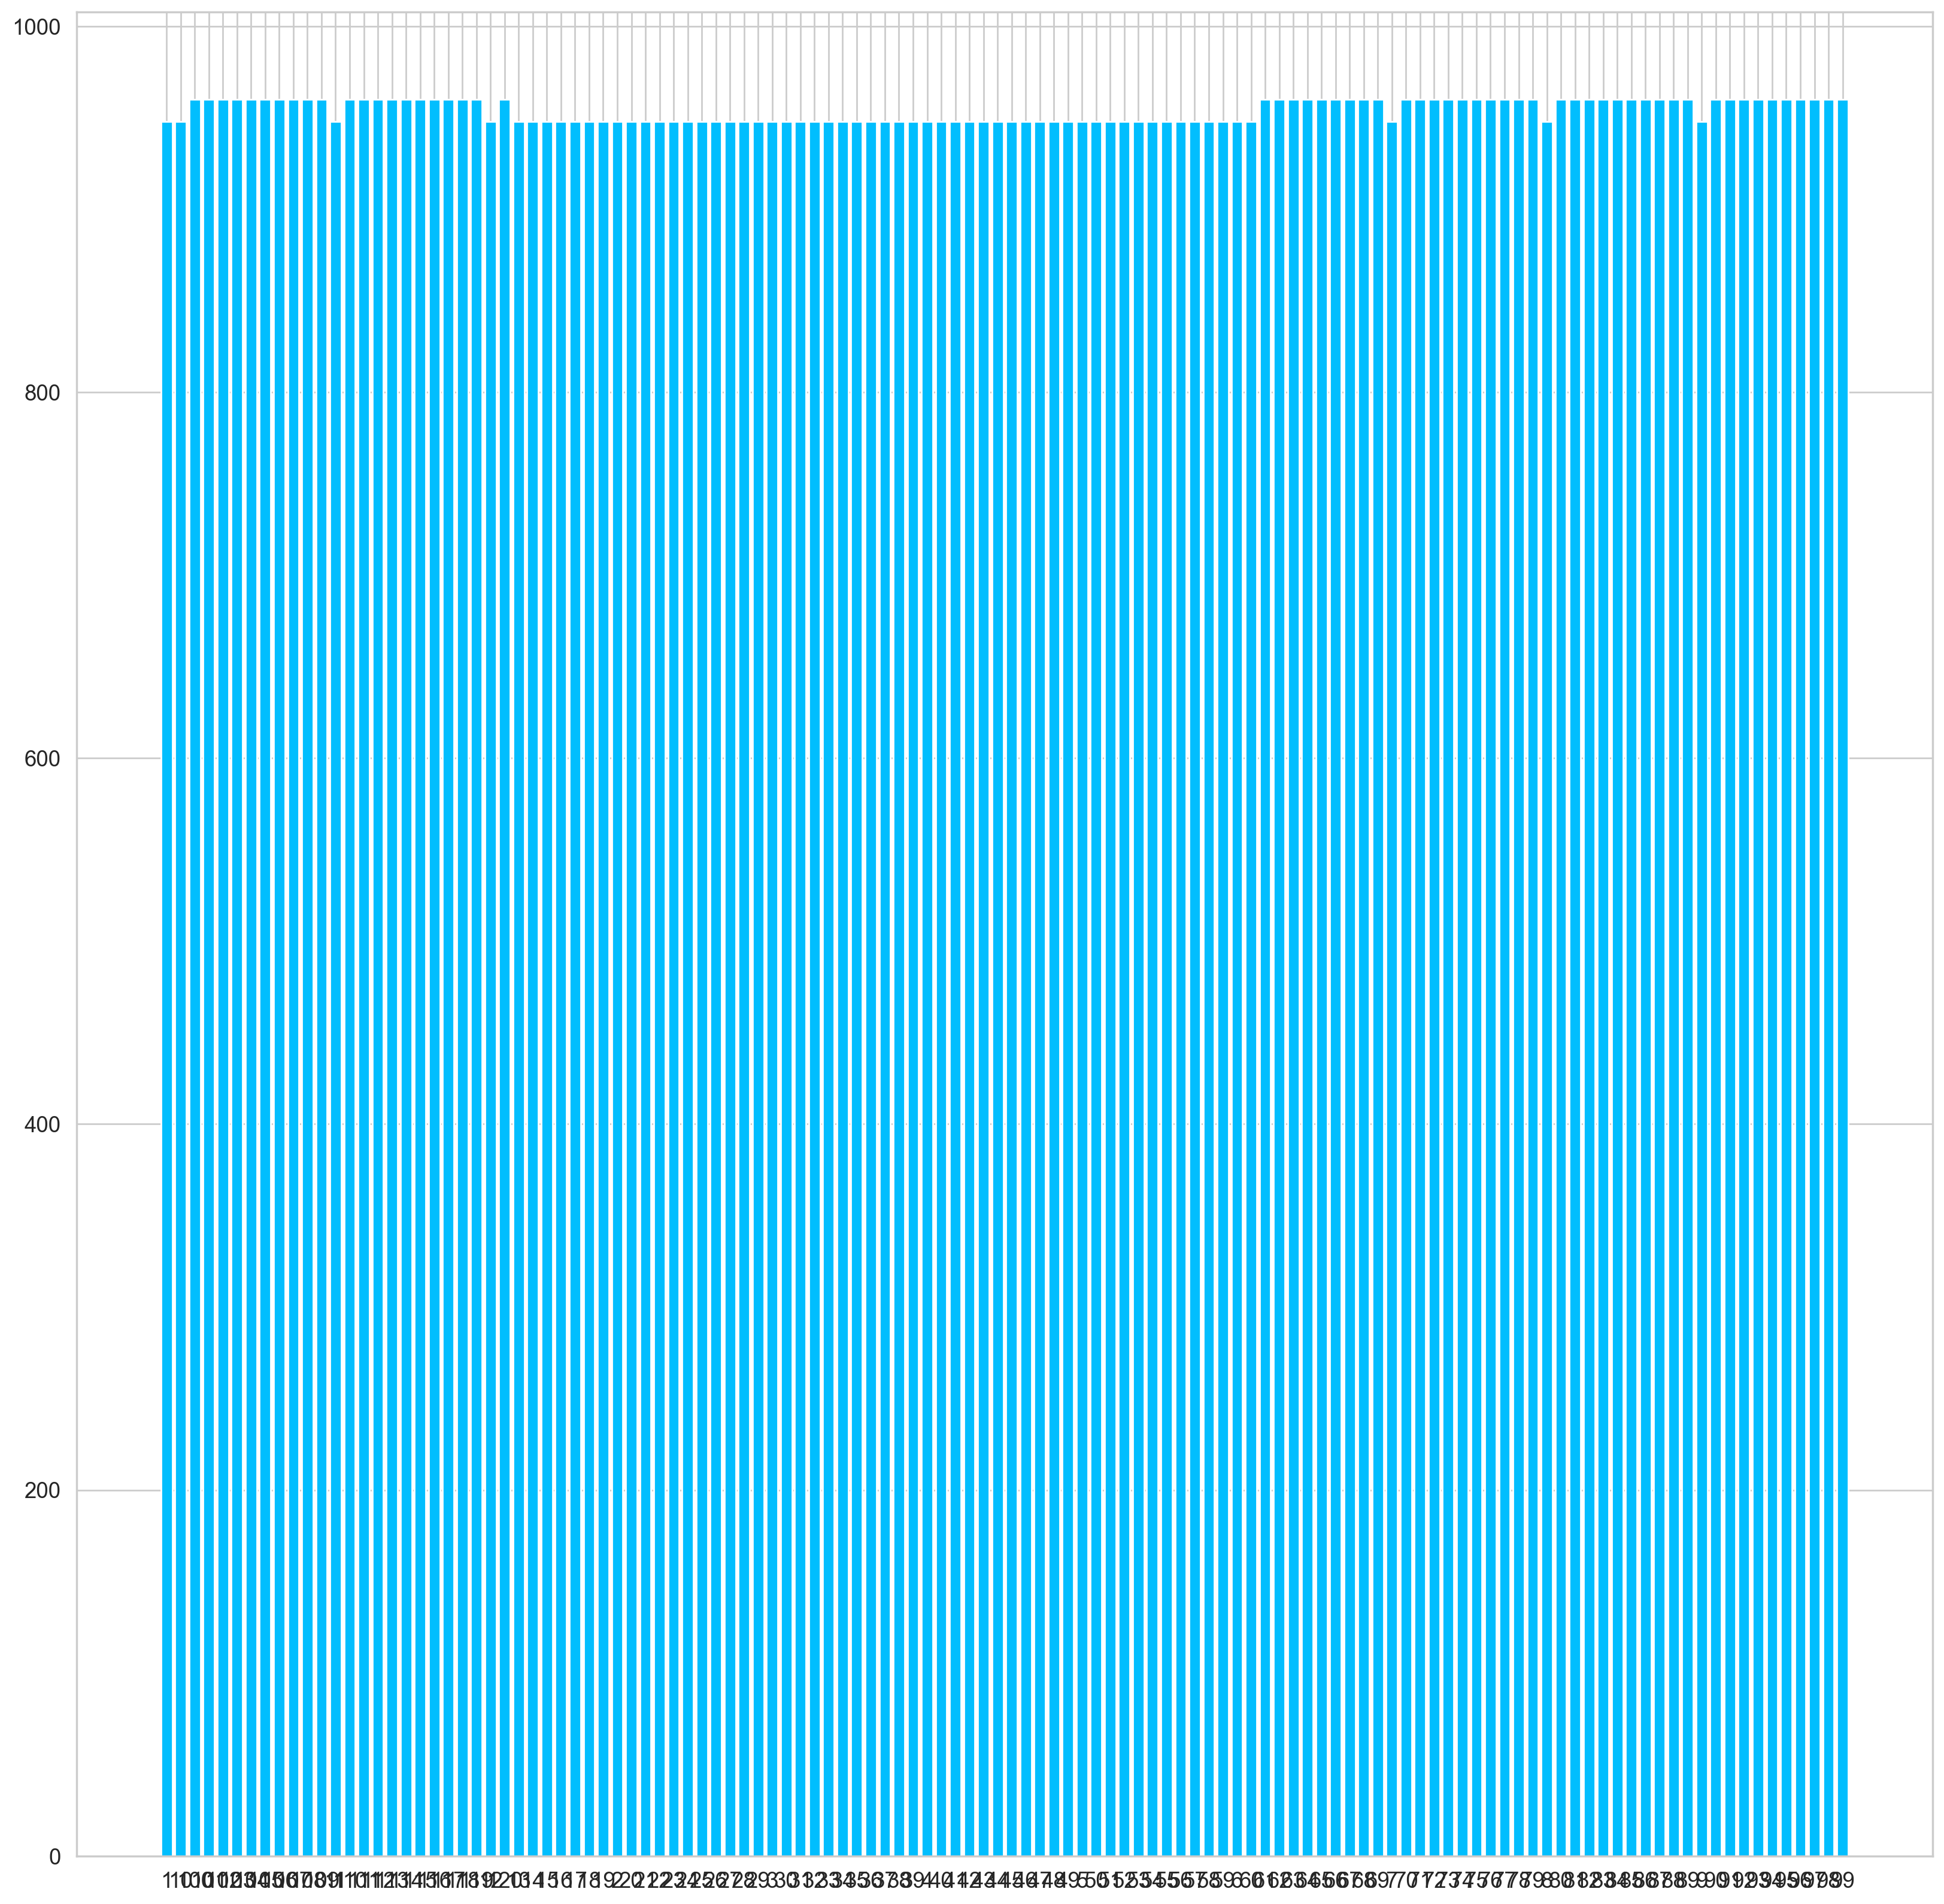

In [24]:
import pandas as pd
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20, 20))

plt.bar(unique_val, unique_count)

# Show Plot
plt.show()

In [25]:
data_dir = os.path.join("E:\\FYP_Data\\NTU120\skel\\nturgbd_skeletons_s001_to_s032\\nturgb+d_skeletons")
remove_files = ["E:\\FYP_Data\\NTU120\\skel\\NTU_RGBD120_samples_with_missing_skeletons.txt","E:\\FYP_Data\\NTU120\\skel\\NTU_RGBD_samples_with_missing_skeletons.txt"]

files_to_remove = set()
for __f in remove_files:
    with open(__f,"r") as f0:
        for val in f0.read().split("\n"):
            files_to_remove.add(val)

total_files = set([x.split(".")[0] for x in os.listdir(data_dir)]) - files_to_remove
total_files_loc = set([f"{os.path.join(data_dir,x)}.skeleton" for x in total_files])

In [26]:
builder = SkeletonFileBuilder(file_names=total_files_loc)
file_iterator = iter(builder)

In [27]:
class_to_num_frames = {}
for __file in tqdm(file_iterator,total=len(file_iterator),desc="Read Files:- "):
    file_name = __file.filepath.split(os.path.sep)[-1].split(".")[0]
    try:
        class_to_num_frames[file_name[-3:]].append(__file.load_data()[0])
    except KeyError:
        class_to_num_frames[file_name[-3:]] = [__file.load_data()[0]]

Read Files:- :   0%|          | 411/113945 [00:13<1:02:51, 30.10it/s]


KeyboardInterrupt: 

In [ ]:
with open("class_to_num_frames","w") as f0:
    json.dump(class_to_num_frames,f0)